# Bootstrap sampling

In [71]:
import xarray as xr
import numpy as np
import sys
import random
from scipy import stats
import glob
from resampling import _resample_iterations_idx
from definitions import * # imports all functions from definitions.py

xr.set_options(keep_attrs = True, display_style = 'html')  # Attributes of DataArrays will be kept through operations.

alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/PW_GW_analysis/'
dir_path = '/home/hochatmstud/bene/'

In [72]:
def g_kde(y, x):
    """Firstly, kernel density estimation of the probability density function of randomized anomalies.
    Secondly, evaluates the estimated pdf on a set of points.
    
    Args:
        y (np.array): datapoints to estimate from (randomized anomalies)
        x (np.array): datapoints to be evaluated (composite values)
    Returns:
        np.array: the estimated pdf on composite values
    """
    print(y)
    mask = np.isnan(y)
    kde = stats.gaussian_kde(y[~mask])
    return kde(x)

In [73]:
station = 'Leipzig'

## Wind measurements

In [74]:
ds_wind = read_group('wind',station)

u = read_var(ds_wind,'u0')
v = read_var(ds_wind,'v0')

u_anomalie = anomalie('dayofyear',u)

v_anomalie = anomalie('dayofyear',v)

sea_u = sea(40,station,u)
sea_u_anomalie = sea(40,station,u_anomalie)

sea_v = sea(40,station,v)
sea_v_anomalie = sea(40,station,v_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [75]:
#var = sys.argv[1] # ta, ua ; input variable
time_scale = sys.argv[2] # 20 or 30 ; input timescale
its = 10000 # 10000 ; number of samples
#what = sys.argv[4] # anomalies ; what kind of anomalies
#DJF_bool = sys.argv[5] # DJF only (bool)
rechunk = True # allows rechunking in xr.apply_ufunc

if station == 'Leipzig':
    size = 7
elif station == 'Esrange':
    size = 11
elif station == 'Sodankyla':
    size = 4
elif station == 'Sodankyla_Kiruna':
    size = 11
elif station == 'CMOR':
    size = 9
elif station == 'RioGrande':
    size = 4
elif station == 'Davis':
    size = 7

line_width = 5

In [76]:
#u_anomalie
u_anomalie['name'] = 'statistical significance'

### for-loop via the lags

In [77]:
u_anomalie = u_anomalie.sel(alt=slice(80,100)).dropna('time')

In [78]:
sea_u_anomalie = sea_u_anomalie.sel(alt=slice(80,100)).dropna('days')

In [79]:
p = []

for lag in range(-40,41,1):
    #print(comp_name, size)
    # samples generation (loaded from external function)
    rnd_arr = _resample_iterations_idx(u_anomalie, 
                                    its, 'time', replace=True, chunk=False, dim_max = size) 
    #print(rnd_arr)
    print("".ljust(line_width)+'{} samples generated'.format(its))
    ## load of composite dataarray
    #comp_file = f'{root_path}composites_woSSW{w_clim}/{var}_{what}_comp_{comp_name}_{time_scale}days.nc'
    #ds_comp = xr.open_dataarray(comp_file)*factor
    #print("".ljust(line_width)+'{} opened'.format(comp_file))
    
    # statistical significance calculation (vectorized g_kde)
    da_kde = xr.apply_ufunc(g_kde, rnd_arr, sea_u_anomalie.sel(days=lag),\
                       input_core_dims=[['iteration'], []],\
                       vectorize=True, dask='parallelized',\
                       exclude_dims=set(("iteration",)),  \
                       output_core_dims=[[]], \
                       output_dtypes=[sea_u_anomalie['u0_mean'].dtype])
    print("".ljust(line_width)+'p-values calculated')
    # output the calculation                        
    #outfile_name = f'{dir_path}bootstrap_test_{station}_lag_{lag}.nc'
    da_kde['name'] = u_anomalie['name']
    #da_kde.to_netcdf(outfile_name)
    #print("".ljust(line_width)+'{} saved'.format(outfile_name))
    #del da_kde, rnd_arr, ds_comp
    #print()
    #da_kde.plot.scatter(y='alt', x='u0_mean')
    #da_kde.plot.scatter(y='alt', x='u0_std')
    p.append(da_kde) 

     10000 samples generated
[ 0.58690476 -4.51742177  1.32386054 ... -2.09368707 -0.93038095
  2.75815646]
[ 1.2824932  -5.09945238  1.15388776 ... -2.81314966 -2.18546599
  2.61078231]
[ 1.16404762 -4.31158844  1.24437755 ... -2.82570748 -2.56414966
  1.95464966]
[ 0.33230952 -3.78318027  1.44333333 ... -1.6532449  -2.55073129
  1.12932653]
[-0.79666667 -3.65313946  1.49772449 ... -0.03319728 -2.22917007
 -0.06020748]
[-1.90305442 -2.81181633  1.47869728 ...  1.39488435 -1.65693878
 -0.94916327]
[-2.70905782 -1.92388776  0.5505068  ...  3.07010204 -0.70294218
 -1.1667415 ]
[-3.68160204 -0.91603061 -0.25563946 ...  5.69442517  0.72512925
 -1.58296599]
[-4.55117007  0.43797279 -0.2159932  ...  8.45596939  2.25962245
 -2.29542177]
[-4.80465986  1.89004082 -0.14217347 ... 11.07861224  3.85856122
 -2.88387415]
[-3.07252839  3.47437284  1.48816667 ... 13.72664626  6.14114094
 -2.71079714]
[ 0.58690476 -4.51742177  1.32386054 ... -2.09368707 -0.93038095
  2.75815646]
[ 1.2824932  -5.0994523

[-5.30622449 -1.31005102 -3.14294218 ... -2.89440816  4.15945578
 -0.14059184]
[-5.5892843  -0.76259969 -2.27082156 ... -2.47491313  7.36570748
  2.43629252]
[ 5.34181293 -3.89634354  2.10953401 ... -0.44234694 -3.0812585
  1.01386395]
[ 4.57428231 -4.0032517   2.73840476 ... -1.37070748 -3.75206122
  0.80858503]
[ 3.15912585 -3.96791497  2.61919048 ... -1.60988776 -3.29240136
  0.43502381]
[ 1.60106803 -3.15256803  2.53942177 ... -1.43605442 -2.7139932
  0.48741497]
[-0.38216327 -2.16347619  2.15078231 ... -1.75565306 -0.95272109
  0.78865986]
[-2.1665034  -1.74254762  1.5912415  ... -2.27779592  1.30661565
  0.76941837]
[-3.30563605 -1.82133673  0.86820408 ... -2.84647619  2.85365306
  0.45388776]
[-3.96796599 -1.09482993 -0.44809864 ... -2.93488095  3.26904762
 -0.12938435]
[-4.57381633 -1.28779252 -1.84794218 ... -2.93343878  3.56365646
 -0.42769388]
[-5.30622449 -1.31005102 -3.14294218 ... -2.89440816  4.15945578
 -0.14059184]
[-5.5892843  -0.76259969 -2.27082156 ... -2.47491313  

     p-values calculated
     10000 samples generated
[ 1.77191497  4.25864966 -3.2954898  ...  3.49139116  3.42879252
 -5.05104422]
[ 1.65622449  1.89861224 -5.41206122 ...  2.41931633  3.36961565
 -5.15655102]
[ 1.49934694 -0.2122619  -6.48494898 ...  1.55082993  2.82931973
 -5.67011224]
[ 1.68392857 -1.31310884 -6.20946939 ...  0.82157483  2.72318367
 -5.81057483]
[ 1.47257823 -1.68030612 -5.44253741 ...  0.10504422  2.27267687
 -5.50153401]
[ 0.72231293 -1.94191497 -5.05785374 ... -0.27194558  1.75968027
 -4.97906122]
[-0.09670748 -2.52048639 -5.00309524 ... -1.52084014  1.08204762
 -3.79969388]
[-0.48664286 -3.63017007 -4.53197959 ... -2.00713605  1.26671088
 -2.55992517]
[-1.20884694 -5.25189456 -3.79897959 ... -1.67135714  1.14721429
 -1.84717347]
[-1.75110544 -7.55141497 -2.69795578 ... -1.30477891  1.3277517
 -2.24558163]
[-2.24556044 -9.93473404 -1.67954528 ...  1.56856502  1.56342072
 -2.23214286]
[ 1.77191497  4.25864966 -3.2954898  ...  3.49139116  3.42879252
 -5.05104422]

[ 3.10943197  1.00511224 -4.20884354 ... -0.52614626  4.95261905
 -1.47847959]
[ 3.30819558  1.63545578 -4.59052381 ...  2.39731293  5.26028571
 -2.10369728]
[ 3.0532466   2.0432483  -4.45663946 ...  4.06260884  5.74890476
 -2.52406463]
[ 2.66084354  2.36504762 -4.67977891 ...  4.8272551   6.197
 -2.37753061]
[ 2.60914456  2.07693197 -4.67806803 ...  4.74235034  6.23533333
 -2.2585034 ]
[ 2.19233844  1.54095578 -3.98106463 ...  4.22738095  6.01861905
 -2.31437415]
[ 1.61297449  1.05043878 -2.8709898  ...  3.71363946  5.75247619
 -2.04898299]
[ 2.18007483  4.68136657 -1.91038961 ...  4.26628912  6.47396939
 -1.94784144]
[-0.02768537 -1.07417687  0.11669728 ... -5.58952381  0.92533333
 -0.72285034]
[ 1.01592007  0.49127551 -1.11448299 ... -3.95390476  2.444
 -1.4207415 ]
[ 2.08540816  0.7250068  -2.76314966 ... -2.49678231  3.85490476
 -1.33692857]
[ 3.10943197  1.00511224 -4.20884354 ... -0.52614626  4.95261905
 -1.47847959]
[ 3.30819558  1.63545578 -4.59052381 ...  2.39731293  5.260285

[-1.80132313 -6.24347619 -4.11720748 ...  4.75214286  1.25784354
  2.46804762]
[-1.56862925 -7.73982653 -5.89771769 ...  5.1617585   1.44444898
  2.85090476]
[ 0.26182746 -6.6170616  -8.48187446 ...  7.26150744  0.01284447
  3.3648658 ]
     p-values calculated
     10000 samples generated
[ 2.26710204  2.46965306 -0.77636395 ... -4.0382449  -3.36408844
  3.40607483]
[ 1.05866327  2.80051701 -1.37520068 ... -4.80054422 -3.7010102
  1.7119932 ]
[ 0.37919388  2.22892517 -0.93596939 ... -5.70660884 -4.46091837
 -0.29045238]
[ 0.47433673  0.8525     -0.37902721 ... -7.34243878 -4.82391156
 -2.0335102 ]
[ 1.29307143 -0.55330612  0.24557823 ... -8.01079252 -4.70038435
 -3.30422449]
[ 2.63503741 -0.43614626  1.16058844 ... -8.1470102  -3.84748639
 -3.51570748]
[ 3.97914966 -0.11922789  2.36871088 ... -7.82363946 -2.91278912
 -3.37519728]
[ 4.98504422  0.32811905  4.18418367 ... -6.87847279 -2.11453401
 -3.66091837]
[ 5.51456463  0.7699898   5.85180612 ... -5.67671769 -0.85356803
 -3.8337449 ]

     10000 samples generated
[-4.43267007  8.05713265  1.17957483 ... -3.76481973  2.028
 -3.87500078]
[-3.7740068   9.24539796 -0.01845578 ... -3.44779592  0.33839116
 -3.598     ]
[-2.8602483   9.46908503 -1.23890816 ... -3.60153061 -1.39317347
 -3.38450628]
[-1.67821429  9.28819048 -2.28415986 ... -3.30002041 -3.13447279
 -3.31886081]
[-0.20885034  8.64228231 -2.38591156 ... -2.91758844 -3.89327891
 -3.27232915]
[ 1.46673129  7.98120068 -2.24651361 ... -2.56160884 -4.23356463
 -2.99544976]
[ 3.13209524  7.3192381  -1.86903061 ... -2.16051701 -4.30428571
 -2.96514521]
[ 4.60637415  6.53178571 -1.55217347 ... -1.41305442 -4.57303741
 -2.67175092]
[ 5.99711224  5.28490816 -2.15280952 ... -0.74637755 -4.87685034
 -2.37321324]
[ 7.34746939  3.59476531 -3.09698299 ...  0.19386395 -4.85732993
 -1.57837624]
[ 5.99783333  4.15708844 -4.43697588 ...  2.32280921 -3.97242092
 -0.09538861]
[-4.43267007  8.05713265  1.17957483 ... -3.76481973  2.028
 -3.87500078]
[-3.7740068   9.24539796 -0.01845

[-2.35273609 -1.02199032 -3.20832653 ... -2.48895238  1.78704108
 -4.50604212]
[ 6.40737755  7.21328571  8.52209524 ... 10.43251361  3.80665306
  2.11148639]
[6.85926871 5.51188776 7.71966667 ... 9.45967347 3.66184694 3.43411565]
[6.13720408 3.84704422 6.16304762 ... 8.2014966  3.45521769 4.13111224]
[5.2537585  1.8980034  4.45642857 ... 6.92085034 2.37452721 3.79822449]
[ 4.27164286 -0.09396259  2.10733333 ...  5.45205102  0.84751701
  2.7765034 ]
[ 2.94839456 -1.8505102   0.07995238 ...  4.18341497 -0.93091837
  1.79383333]
[ 1.92840136 -3.03989796 -1.18319048 ...  3.2492585  -1.99929932
  0.6284898 ]
[ 0.70148299 -3.83628912 -2.20233333 ...  2.11260544 -1.98762585
 -0.02513265]
[-0.05819388 -3.74756122 -3.93542857 ...  0.33068027 -0.89476531
 -0.96094558]
[-0.91941497 -2.47268367 -4.37466667 ... -1.70359184 -0.83247279
 -1.9200034 ]
[-2.35273609 -1.02199032 -3.20832653 ... -2.48895238  1.78704108
 -4.50604212]
     p-values calculated
     10000 samples generated
[-1.11179252  4.589

     p-values calculated
     10000 samples generated
[-0.9592517  -1.15270068  2.52470068 ... -1.09473469  2.89088776
  5.30983673]
[-0.27645578 -1.96022789  3.09491837 ... -0.26028571  0.76733333
  6.1992619 ]
[-0.15064286 -2.91228912  3.36059184 ...  0.59762925 -0.75639796
  5.96053741]
[ 0.11180952 -3.25478231  2.72831973 ...  1.57613265 -1.89782313
  4.91622449]
[ 0.04543197 -3.46581293  3.25495578 ...  2.08461905 -2.95359184
  3.51312925]
[ 0.02414286 -3.71468367  3.82802721 ...  2.03446259 -4.00868367
  2.48269388]
[-0.24679252 -3.5374898   4.01903061 ...  1.32070068 -4.25143537
  1.62284014]
[-0.1085068  -3.02034014  3.88490816 ...  1.04839116 -4.73278231
  0.85888095]
[ 0.46936054 -2.24385374  3.17663946 ...  0.83413946 -5.28893197
  0.02917347]
[ 1.60271088 -0.82694558  1.64743197 ... -0.08914286 -5.20182653
 -0.8307449 ]
[ 3.43707012  0.8290102   0.85422109 ... -0.48632692 -3.71383241
 -3.05955324]
[-0.9592517  -1.15270068  2.52470068 ... -1.09473469  2.89088776
  5.30983673

     10000 samples generated
[-1.69655442  2.82528912  0.96107483 ... -2.75313605 -7.12306463
 -2.36209184]
[-1.70092857  2.92056803 -0.64523129 ... -2.46914626 -7.02981973
 -2.5077483 ]
[-2.75958503  3.41377551 -2.48940816 ... -2.07615646 -6.8472483
 -2.06191156]
[-3.32116327  3.66911905 -3.57053061 ... -0.45481633 -6.79085714
 -1.44262585]
[-3.99252721  3.8675068  -3.87365646 ...  0.23639796 -6.8227585
 -1.02106122]
[-4.17919048  3.25360544 -3.29634694 ...  0.87686395 -6.48751701
 -0.83334354]
[-3.63109864  2.43078231 -2.61987075 ...  0.9484932  -5.39213946
 -0.20415646]
[-3.36667687  1.40458503 -1.9490102  ...  0.82606463 -4.59244558
  0.34508844]
[-3.19004422  0.88329592 -0.96534694 ...  0.88515986 -4.08531293
  0.82240476]
[-3.03505782  0.49085714 -0.03314286 ...  0.23798639 -3.36937415
  1.45521429]
[-0.20179592  5.26018963  1.29149474 ... -0.08967936 -2.19590659
 -0.5279966 ]
[-1.69655442  2.82528912  0.96107483 ... -2.75313605 -7.12306463
 -2.36209184]
[-1.70092857  2.92056803 

[ 1.99438776 -4.69219728 -1.97390476 ... -3.32216667  0.14022449
 -3.58796259]
[ 3.0312864  -4.24918229 -0.80398823 ... -2.6229304  -0.41539796
 -3.2422604 ]
[-3.22792517  1.78832313  3.86185714 ... -2.76439456 -3.55402721
 -1.87477891]
[-3.71618367  0.15586395  1.54732313 ... -3.40170748 -2.48736735
 -2.03708503]
[-4.06208844 -0.91248299 -0.35803401 ... -3.46429592 -0.91901701
 -1.67220748]
[-3.95739456 -1.62518027 -1.47298639 ... -3.1375068   0.63577551
 -1.23786735]
[-2.90927551 -1.90220748 -2.30427211 ... -3.14633673  1.26932993
 -0.49247619]
[-0.65622449 -2.42834014 -2.44414286 ... -3.12561565  1.0484932
 -0.04898639]
[ 0.61135374 -3.36926531 -2.87639116 ... -3.14848299  0.52217347
 -0.02409184]
[ 1.10282653 -3.59014966 -3.3747585  ... -3.35408844  0.54311224
 -0.78727551]
[ 1.4297585  -3.82633333 -3.26317347 ... -3.47076531  0.69729932
 -2.19454082]
[ 1.99438776 -4.69219728 -1.97390476 ... -3.32216667  0.14022449
 -3.58796259]
[ 3.0312864  -4.24918229 -0.80398823 ... -2.6229304  

[-2.81139456  1.51018367  4.86090816 ...  2.10518367 -2.17894558
  2.36797279]
[-3.0052585   2.65913946  4.63455102 ...  1.54285034 -2.76769048
  3.39038776]
[-2.9169966   3.13107143  4.26216327 ...  1.43687075 -3.10146599
  3.86965646]
[-2.2722551   4.0432619   3.65748299 ...  1.58923129 -3.32114626
  3.76668367]
[-1.07930612  5.71320408  2.44071769 ...  1.54385374 -3.60680952
  4.51545918]
[ 0.4534898   7.48325275  3.46735374 ...  0.25754174 -1.48635374
  1.27620663]
     p-values calculated
     10000 samples generated
[-0.63262245 -3.92890398  1.89838776 ... -1.0397619   8.1347619
  0.29588095]
[ 1.15870408 -6.18552826  0.80584354 ...  0.59633333  8.68514286
  1.56431293]
[ 2.60177891 -7.33046651  0.52395238 ...  1.80261905  8.88042857
  2.42168367]
[ 2.96486395 -7.54594532  0.47720408 ...  3.28614286  8.42547619
  3.05883333]
[ 2.98242517 -7.44699791  0.31912585 ...  3.76309524  7.94433333
  3.48514286]
[ 2.88242177 -7.40611277  0.36647279 ...  4.0962381   6.88680952
  2.76313265]

     10000 samples generated
[ 1.35370748 -0.87255102  0.40871769 ...  7.50962585 -8.53279932
 -3.19901361]
[ 1.9642517  -0.52721769 -0.26361905 ...  6.14634014 -9.19523129
 -3.53876531]
[ 2.32252721 -0.87685034 -0.88443537 ...  4.91364286 -9.03885034
 -3.31481973]
[ 2.53403401 -1.26890476 -0.97931973 ...  3.51439456 -8.19953061
 -2.95757483]
[ 2.3342381  -1.50167687 -1.17048639 ...  2.49916667 -6.80209524
 -2.82494218]
[ 1.70854422 -1.89965986 -1.47670068 ...  2.35017347 -4.95821429
 -2.10494218]
[ 1.2827517  -2.31583673 -1.46761565 ...  2.7082381  -3.21737075
 -1.64080272]
[ 0.75170068 -2.1417517  -1.11110544 ...  3.76411224 -1.32631973
 -1.78818367]
[ 0.02360884 -1.92518367 -1.18821429 ...  4.19754422  0.5112483
 -2.03739796]
[-1.49677211 -1.79614626 -2.09065646 ...  4.12408844  1.94543537
 -1.91903741]
[-1.44042648 -0.52887755 -3.29304584 ...  5.40358809  1.70812075
 -1.2926821 ]
[ 1.35370748 -0.87255102  0.40871769 ...  7.50962585 -8.53279932
 -3.19901361]
[ 1.9642517  -0.52721769

[ 1.15942177 -4.64541156  0.69102721 ... -7.9542619   0.34914626
 -3.50677891]
[ 1.75602721 -5.01826531 -0.64452721 ... -5.9672483  -0.30377551
 -2.33488776]
[ 2.4389932  -5.06097959 -1.44370748 ... -3.45184014 -0.57454422
 -1.44381973]
[ 2.71694558 -4.11811905 -1.66994218 ... -1.88854082 -1.19702381
  0.39287075]
[ 2.14126531 -2.78702041 -2.08304082 ... -1.17355782 -2.60969048
  1.79959864]
[ 1.37315646 -1.58896939 -2.55123469 ... -0.90541837 -3.77022449
  2.50509524]
[ 0.55136054 -0.58864626 -2.53586735 ... -0.43315986 -4.51964286
  2.26812925]
[-0.16487075 -0.04151361 -2.67377211 ...  0.66081293 -5.46389456
  2.01217007]
[-0.54504422  0.4370034  -3.01754422 ...  1.88860884 -5.56056463
  1.60611905]
[-1.2627619   3.14267038 -2.3085781  ... -2.20769898 -5.53803231
  4.95147579]
     p-values calculated
     10000 samples generated
[ 6.24509524 -0.51738095 -0.36244898 ... -3.6092619  -2.23179252
 -0.25588095]
[ 5.59266667 -0.0417619  -1.52535714 ... -0.76662585 -1.63947619
  0.72838435

In [80]:
p_comp =  xr.concat(p, dim = 'days')
p_comp['days'] = range(-40, 40+1)
p_comp = p_comp.where(p_comp['u0_mean'] < 0.05, other = -0.05)

In [81]:
#p_comp

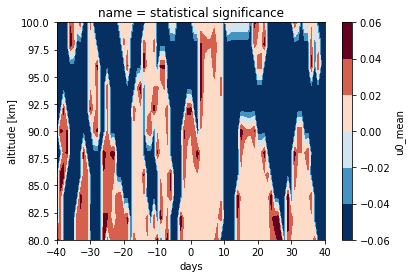

In [82]:
p_comp['u0_mean'].plot.contourf(x='days')